In [1]:
import cv2
from easy_ViTPose import VitInference
import matplotlib.pyplot as plt
import os
import numpy as np
from huggingface_hub import hf_hub_download

/cluster/tufts/fuzzywuzzy/jbrand12/condaenv/fzwz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_SIZE = 'h'
YOLO_SIZE = 'n'
DATASET = 'apt36k'
ext = '.pth'
ext_yolo = '.pt'

In [3]:
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo

print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

In [4]:
# If you want to use MPS (on new macbooks) use the torch checkpoints for both ViTPose and Yolo
# If device is None will try to use cuda -> mps -> cpu (otherwise specify 'cpu', 'mps' or 'cuda')
# dataset and det_class parameters can be inferred from the ckpt name, but you can specify them.
model = VitInference(model_path, yolo_path, MODEL_SIZE, dataset=DATASET)

In [6]:
# Image to run inference RGB format
img = cv2.imread('../sample_data/red_lasers/sample_data/3-Feb-2016-294.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

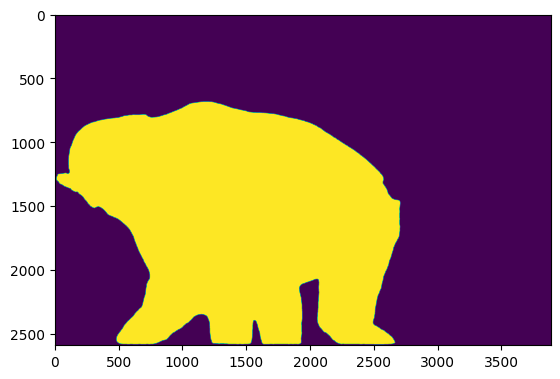

In [8]:
mask = cv2.imread('../sample_data/red_lasers/sample_data_masks/3-Feb-2016-294_mask.png', cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale
# mask = mask > 0  # need to convert to boolean values

# To select the inverse of the mask:
inverse_mask = np.logical_not(mask)

plt.imshow(mask)

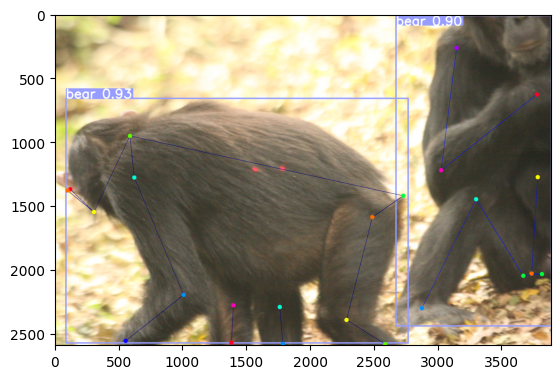

In [9]:
# Infer keypoints, output is a dict where keys are person ids and values are keypoints (np.ndarray (25, 3): (y, x, score))
# If is_video=True the IDs will be consistent among the ordered video frames.
keypoints = model.inference(img)
output = model.draw(show_yolo=True)  # Returns RGB image with drawings
plt.imshow(output)

In [11]:
len(keypoints)

2

### Create bounding box from mask

In [54]:
def crop_image(img, mask):
    # Find the coordinates of non-zero pixels
    y_indices, x_indices = np.nonzero(mask)
    
    # Determine the bounding box coordinates
    x1, y1 = np.min(x_indices), np.min(y_indices)
    x2, y2 = np.max(x_indices), np.max(y_indices)

    # Crop the image to the bounding box
    cropped_img = img[y1:y2, x1:x2]
    
    # Resize the cropped image to the target size
#     resized_img = cv2.resize(cropped_img, img.shape[1::-1], interpolation=cv2.INTER_AREA)
    
    return cropped_img, (x1, y1)

In [59]:
def map_keypoints_to_original(detected_keypoints, offset):
    x_offset, y_offset = offset
    adjusted_keypoints = {}
    for person_id, keypoints in detected_keypoints.items():
        # Add the offset to the x and y coordinates (first two columns)
        adjusted_kps = keypoints.copy()
        adjusted_kps[:, 0] += x_offset
        adjusted_kps[:, 1] += y_offset
        adjusted_keypoints[person_id] = adjusted_kps
    return adjusted_keypoints

In [61]:
def draw_keypoints_on_original_image(original_img, adjusted_keypoints):
    # Copy the original image to avoid modifying it directly
    img_with_keypoints = np.copy(original_img)
    
    # Iterate through each person's keypoints
    for person_id, keypoints in adjusted_keypoints.items():
        # Draw each keypoint
        for x, y, confidence in keypoints:
            # Convert coordinates to integers and draw the circle
            center = (int(x), int(y))
            color = (0, 255, 0)  # Green color for the keypoints
            cv2.circle(img_with_keypoints, center, 5, color, -1)  # Radius=5, Filled circle
    
    return img_with_keypoints

In [56]:
# Example usage
cropped_image, offset = crop_image(img, mask)
keypoints_cropped = model.inference(cropped_image)
keypoints = map_keypoints_to_original(keypoints_cropped, offset)

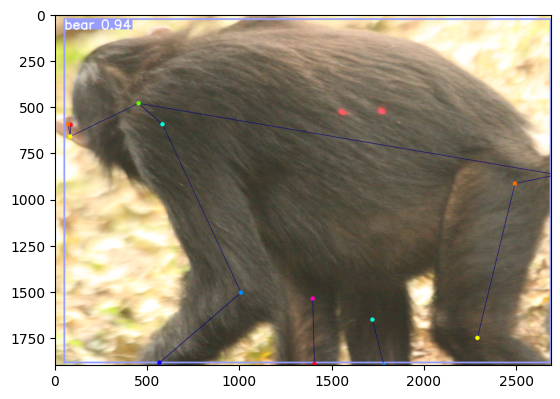

In [60]:
output = model.draw(show_yolo=True)  # Returns RGB image with drawings
plt.imshow(output)

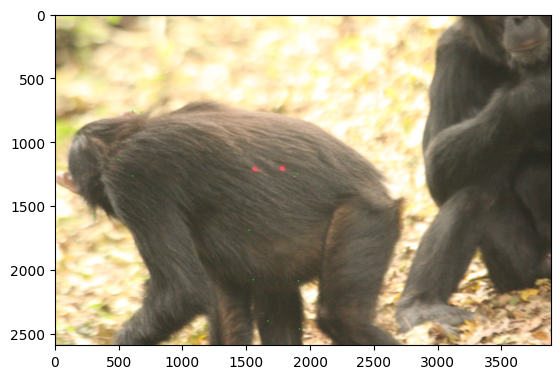

In [63]:
img_with_keypoints = draw_keypoints_on_original_image(img, keypoints)
plt.imshow(img_with_keypoints)

In [64]:
import json
# path to json file
json_file = 'red_lasers/im_data.json'

# folder containing images
image_folder = 'red_lasers/new_sample_data'

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [65]:
def draw_dots(points, ax):
    ax.scatter(points[:, 0], points[:, 1], color='lightblue', s=5)

red_lasers/new_sample_data/3-Feb-2016-294.JPG [1138, 494] [3402, 880]
red_lasers/new_sample_data/6-Oct-2015-186.JPG vitpose failed
red_lasers/new_sample_data/3-Feb-2016-565.JPG [2126, 393] [3395, 535]
red_lasers/new_sample_data/4-Feb-2016-247.JPG [3104, 436] [1980, 781]
red_lasers/new_sample_data/3-Nov-2015-417.JPG [2843, 181] [1784, 271]
red_lasers/new_sample_data/4-Dec-2015-4.JPG [2231, 13] [1640, 543]
red_lasers/new_sample_data/30-Oct-2015-157.JPG vitpose failed
red_lasers/new_sample_data/10-Feb-2016-134.JPG [1806, 326] [3183, 712]


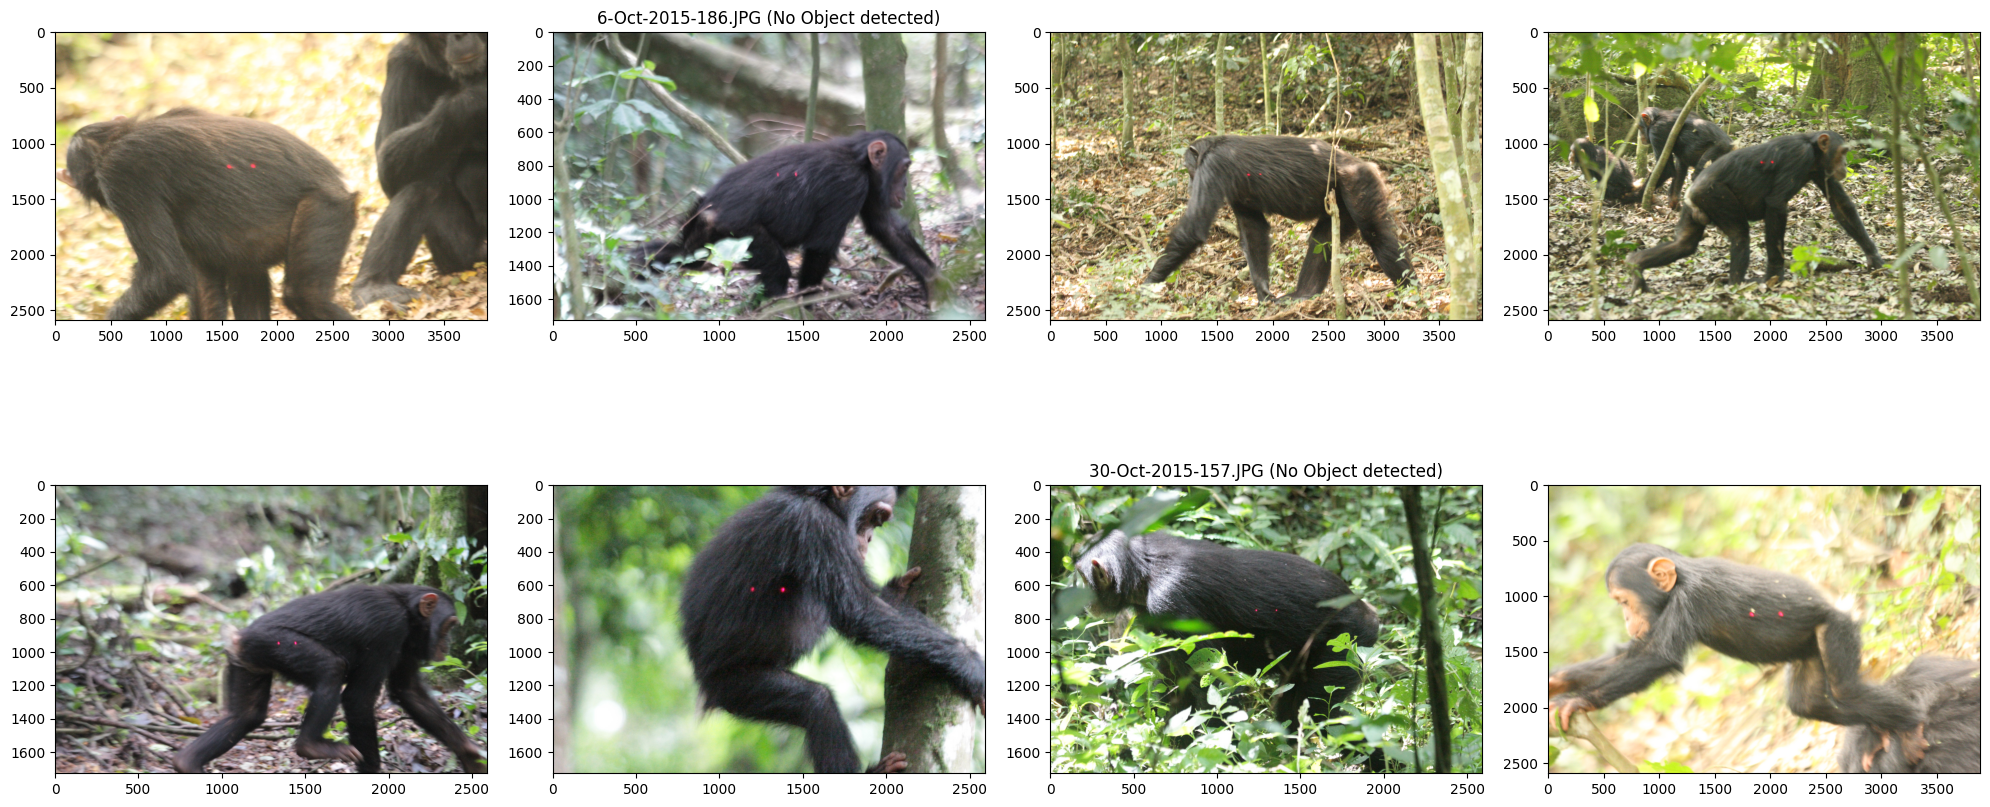

In [66]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# flatten axes for easy indexing
axs = axs.flatten()

idx = 0

# iterate through each entry in json
for image_name, info in image_data.items():
    image_path = os.path.join(image_folder, image_name)
    print(image_path, end=' ')
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting
    
    cropped_image, offset = crop_image(img, mask)
    keypoints_cropped = model.inference(cropped_image)
    keypoints = map_keypoints_to_original(keypoints_cropped, offset)

    if keypoints:
      shoulder = keypoints[0][3]
      shoulder = [int(shoulder[1]), int(shoulder[0])]

      rump = keypoints[0][4]
      rump = [int(rump[1]), int(rump[0])]

      # draw results
#       img = model.draw(show_yolo=True)
#       axs[idx].set_title(image_name)

      # Update the JSON data with shoulder and rump
      image_data[image_name]['shoulder'] = shoulder
      image_data[image_name]['rump'] = rump
      print(shoulder, rump)
    else:
      print("vitpose failed")
      image_data[image_name]['shoulder'] = [0, 0]
      image_data[image_name]['rump'] = [0, 0]
      axs[idx].set_title(f"{image_name} (No Object detected)")

    axs[idx].imshow(img)
    idx+=1

plt.tight_layout()
plt.show()

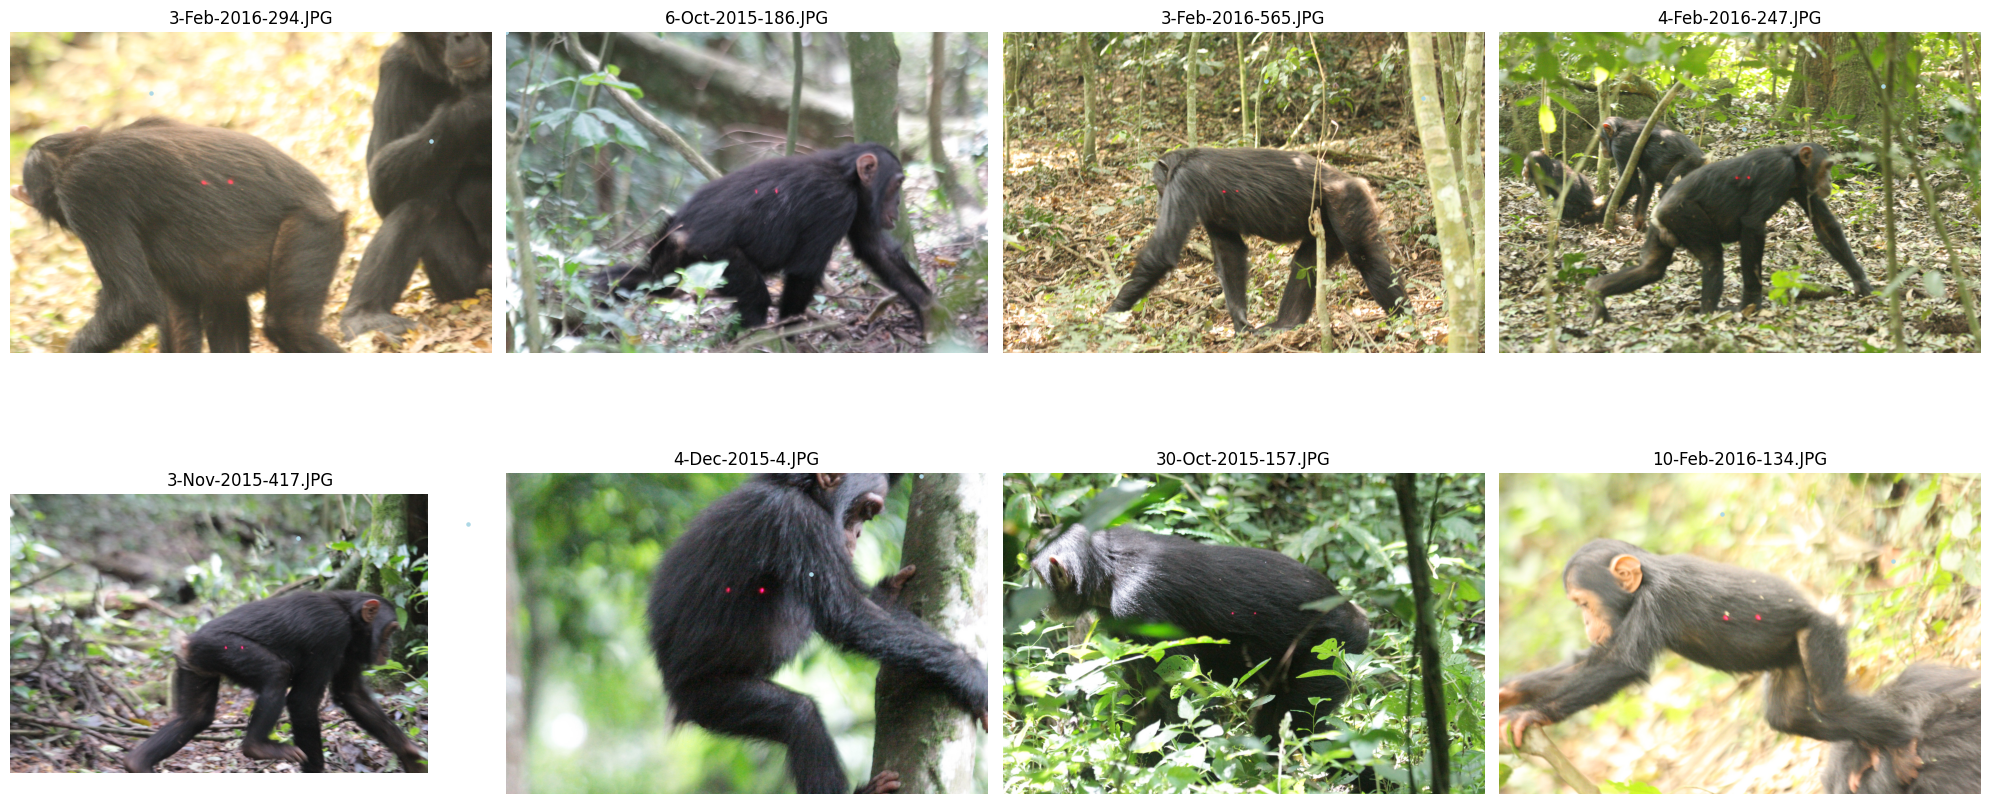

In [67]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# flatten axes for easy indexing
axs = axs.flatten()

idx = 0
# iterate through each entry in json
for image_name, info in image_data.items():
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    if img is not None:
        # extract coordinates
        points = np.array([info['shoulder'], info['rump']])

        # plot image
        axs[idx].imshow(img)
        if len(points != 0):
            draw_dots(points, axs[idx])
            axs[idx].set_title(image_name)
        else:
            axs[idx].set_title(f"{image_name} (No points detected)")
        axs[idx].axis('off')

        idx += 1
    else:
        print(f"Could not load image: {image_name}")

plt.tight_layout()
plt.show()